# Plagiarism Detection using Hashing and Sentence Embeddings

This notebook implements MinHash and Sentence Embeddings to detect plagiarism in the provided dataset.

In [1]:
import pandas as pd
import numpy as np
import re
import hashlib
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Try importing sentence_transformers
try:
    from sentence_transformers import SentenceTransformer
    SENTENCE_TRANSFORMERS_AVAILABLE = True
    print("sentence_transformers is available.")
except ImportError:
    SENTENCE_TRANSFORMERS_AVAILABLE = False
    print("sentence_transformers not found. Will use TF-IDF fallback.")

sentence_transformers is available.


In [2]:
# Load Data
data_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(data_path)
df.head()

,File,Task,Category,category_id,plag_label,raw_text,clean_text
0,g0pA_taska.txt,a,non,0,0,Inheritance is a basic concept of Object-Orien...,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,cut,3,1,PageRank is a link analysis algorithm used by ...,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,light,2,1,"The vector space model (also called, term vect...",the vector space model also called term vector...
3,g0pA_taskd.txt,d,heavy,1,1,Bayes’ theorem was names after Rev Thomas Baye...,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,non,0,0,Dynamic Programming is an algorithm design tec...,dynamic programming is an algorithm design tec...


## 1. MinHash Implementation

We will implement MinHash from scratch to estimate Jaccard similarity.

In [3]:
class MinHash:
    def __init__(self, num_perm=128, seed=42):
        self.num_perm = num_perm
        self.seed = seed
        self.permutations = self._generate_permutations()

    def _generate_permutations(self):
        # Generate random coefficients for hash functions: (a*x + b) % c
        random.seed(self.seed)
        max_val = (2**32) - 1
        perms = []
        for _ in range(self.num_perm):
            a = random.randint(1, max_val)
            b = random.randint(0, max_val)
            perms.append((a, b))
        return perms

    def get_shingles(self, text, k=3):
        # Create k-shingles (n-grams) from text
        text = str(text).lower()
        # Simple tokenization by splitting on whitespace
        tokens = text.split()
        if len(tokens) < k:
            return set([text])
        
        shingles = set()
        for i in range(len(tokens) - k + 1):
            shingle = " ".join(tokens[i:i+k])
            shingles.add(shingle)
        return shingles

    def compute_signature(self, text, k=3):
        shingles = self.get_shingles(text, k)
        signature = [float('inf')] * self.num_perm
        
        # Hash each shingle and update signature
        for shingle in shingles:
            # Use a stable hash of the shingle string as 'x'
            # We use sha256 and take first 8 bytes as integer
            hashed_shingle = int(hashlib.sha256(shingle.encode('utf-8')).hexdigest()[:8], 16)
            
            prime = 4294967311 # A prime number > 2^32
            
            for i, (a, b) in enumerate(self.permutations):
                hash_val = (a * hashed_shingle + b) % prime
                if hash_val < signature[i]:
                    signature[i] = hash_val
        
        return signature

    def compute_similarity(self, sig1, sig2):
        if not sig1 or not sig2:
            return 0.0
        
        matches = sum(1 for i in range(self.num_perm) if sig1[i] == sig2[i])
        return matches / self.num_perm

# Initialize MinHash
mh = MinHash(num_perm=128)

# Compute signatures for all documents
print("Computing MinHash signatures...")
df['minhash_sig'] = df['clean_text'].apply(lambda x: mh.compute_signature(x, k=3))
print("Done.")

Computing MinHash signatures...


Done.


## 2. Sentence Embeddings

We will use `sentence_transformers` if available, otherwise TF-IDF.

In [4]:
embeddings = None

if SENTENCE_TRANSFORMERS_AVAILABLE:
    print("Using SentenceTransformer...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['clean_text'].astype(str).tolist(), show_progress_bar=True)
else:
    print("Using TF-IDF...")
    vectorizer = TfidfVectorizer(stop_words='english')
    embeddings = vectorizer.fit_transform(df['clean_text'].astype(str).tolist())

print("Embeddings shape:", embeddings.shape)

Using SentenceTransformer...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Embeddings shape: (100, 384)


## 3. Comparison and Evaluation

We will compute pairwise similarities and compare with the ground truth `plag_label`.
Note: The dataset seems to have 'File', 'Task', 'Category' etc. We should probably compare files within the same 'Task' or just check if the similarity correlates with 'plag_label' (assuming 1 is plagiarized).

In [5]:
# Let's calculate similarity between each file and the 'original' files for the same task if possible.
# Or simply, let's look at the provided 'plag_label'. 
# If plag_label indicates plagiarism, we expect high similarity.

# However, the dataset structure shows 'File', 'Task', 'Category'. 
# It seems 'orig_task*.txt' are the source files.
# Let's identify source files for each task.

source_files = df[df['Category'] == 'orig']
source_map = {}
for _, row in source_files.iterrows():
    source_map[row['Task']] = row['clean_text']

# Function to get similarity with source
def get_similarities(row):
    task = row['Task']
    if task not in source_map:
        return pd.Series([0.0, 0.0], index=['minhash_sim', 'embedding_sim'])
    
    source_text = source_map[task]
    
    # MinHash Sim
    source_sig = mh.compute_signature(source_text)
    mh_sim = mh.compute_similarity(row['minhash_sig'], source_sig)
    
    # Embedding Sim
    # We need the index of the current row and the index of the source file
    # This is a bit tricky with the current structure if we just use the precomputed embeddings matrix.
    # Let's just re-encode or find the index.
    
    # Finding index in the dataframe
    idx = row.name # Assuming default index
    
    # Find source index
    # We need to be careful if source files are in the dataframe.
    # Let's assume they are.
    source_rows = df[(df['Task'] == task) & (df['Category'] == 'orig')]
    if source_rows.empty:
        emb_sim = 0.0
    else:
        source_idx = source_rows.index[0]
        
        if SENTENCE_TRANSFORMERS_AVAILABLE:
             # embeddings is a numpy array
            emb_sim = cosine_similarity([embeddings[idx]], [embeddings[source_idx]])[0][0]
        else:
            # embeddings is sparse matrix
            emb_sim = cosine_similarity(embeddings[idx], embeddings[source_idx])[0][0]

    return pd.Series([mh_sim, emb_sim], index=['minhash_sim', 'embedding_sim'])

print("Computing similarities with source texts...")
sim_scores = df.apply(get_similarities, axis=1)
df = pd.concat([df, sim_scores], axis=1)
print("Done.")

Computing similarities with source texts...


Done.


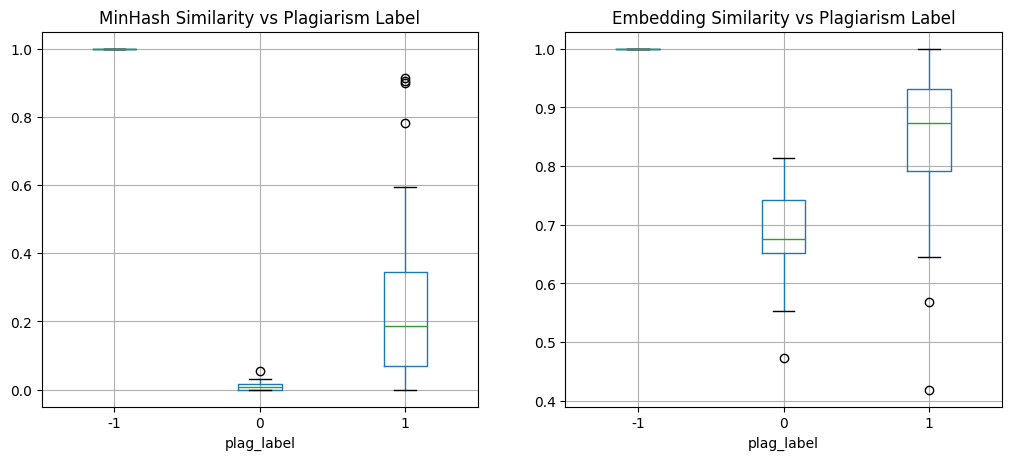

In [6]:
# Visualize Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df.boxplot(column='minhash_sim', by='plag_label', ax=plt.gca())
plt.title('MinHash Similarity vs Plagiarism Label')
plt.suptitle('') # Suppress default title

plt.subplot(1, 2, 2)
df.boxplot(column='embedding_sim', by='plag_label', ax=plt.gca())
plt.title('Embedding Similarity vs Plagiarism Label')
plt.suptitle('')

plt.show()

In [7]:
# Display some examples
print("Examples of High Similarity (Plagiarized):")
print(df[df['plag_label'] == 1][['File', 'Category', 'minhash_sim', 'embedding_sim']].head())

print("\nExamples of Low Similarity (Non-Plagiarized):")
print(df[df['plag_label'] == 0][['File', 'Category', 'minhash_sim', 'embedding_sim']].head())

Examples of High Similarity (Plagiarized):
             File Category  minhash_sim  embedding_sim
1  g0pA_taskb.txt      cut     0.343750       0.843223
2  g0pA_taskc.txt    light     0.406250       0.980362
3  g0pA_taskd.txt    heavy     0.031250       0.786267
7  g0pB_taskc.txt      cut     0.554688       0.946282
8  g0pB_taskd.txt    light     0.210938       0.803781

Examples of Low Similarity (Non-Plagiarized):
              File Category  minhash_sim  embedding_sim
0   g0pA_taska.txt      non     0.007812       0.656402
4   g0pA_taske.txt      non     0.007812       0.772218
5   g0pB_taska.txt      non     0.015625       0.617019
6   g0pB_taskb.txt      non     0.000000       0.668102
11  g0pC_taskb.txt      non     0.000000       0.606285
